In [10]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [11]:
import numpy as np
import pandas as pd

In [12]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [14]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [16]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [31]:
# Calculate the date 1 year ago from the last data point in the database
last = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date, = last
year,month,day = last_date.split('-')
query_date = dt.date(int(year),int(month),int(day)) - dt.timedelta(days=365)
print("Last Date Measured: ",last_date)
print("Query Date: ",query_date)

Last Date Measured:  2017-08-23
Query Date:  2016-08-23


In [42]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).group_by(Measurement.date).all()
rain

[('2016-08-23', 0.7),
 ('2016-08-24', 1.45),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.01),
 ('2016-08-27', None),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.05),
 ('2016-08-31', 2.46),
 ('2016-09-01', 0.01),
 ('2016-09-02', 0.03),
 ('2016-09-03', 1.0),
 ('2016-09-04', 0.44),
 ('2016-09-05', 0.18),
 ('2016-09-06', 1.0),
 ('2016-09-07', 1.35),
 ('2016-09-08', 0.15),
 ('2016-09-09', 0.35),
 ('2016-09-10', 1.16),
 ('2016-09-11', 0.6),
 ('2016-09-12', 1.04),
 ('2016-09-13', 1.2),
 ('2016-09-14', 6.7),
 ('2016-09-15', 3.35),
 ('2016-09-16', 0.61),
 ('2016-09-17', 0.23),
 ('2016-09-18', 0.42),
 ('2016-09-19', 0.25),
 ('2016-09-20', 0.43),
 ('2016-09-21', 1.02),
 ('2016-09-22', 0.75),
 ('2016-09-23', 0.33),
 ('2016-09-24', 0.27),
 ('2016-09-25', 0.04),
 ('2016-09-26', 1.02),
 ('2016-09-27', 1.0),
 ('2016-09-28', 0.05),
 ('2016-09-29', 1.49),
 ('2016-09-30', 0.38),
 ('2016-10-01', 1.02),
 ('2016-10-02', 0.61),
 ('2016-10-03', 0.46),
 ('2016-10-04', 3.46),
 ('2016-10-05', 0.8

In [33]:
# Perform a query to retrieve the data and precipitation scores
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-23,0.70
1,2016-08-24,1.45
2,2016-08-25,0.11
3,2016-08-26,0.01
4,2016-08-27,NaN


In [34]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df_rain = rain_df.set_index("date")
df_rain.head()

,prcp
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN


In [35]:
# Sort the dataframe by date
df_rain.sort_values(["date"]).head()

,prcp
date,
2016-08-23,0.70
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN


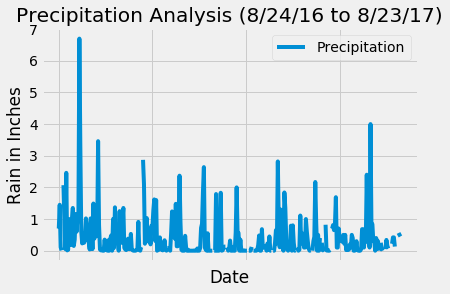

In [38]:
# Use Pandas Plotting with Matplotlib to plot the data
df_rain.plot()
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.show()

In [80]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_rain.describe()

,prcp
count,345.000000
mean,0.432087
std,0.704363
min,0.000000
25%,0.010000
50%,0.140000
75%,0.580000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).group_by(Measurement.station).count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [50]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Measurement.station,
                                 func.count(Measurement.station))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.station).desc())

# List the stations and the counts in descending order.
for row in station_activity:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [64]:
top_station = station_activity[0][0]
print(f"{top_station} is the most active station")

USC00519281 is the most active station


In [84]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

rec_top_station = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == top_station).all()

print(f"Station: {top_station}\n\
    Lowest temperature recorded:  {rec_top_station[0][0]}\n\
    Highest temperture recorded :  {rec_top_station[0][1]}\n\
    Average temperature recorded:  {rec_top_station[0][2]}")


Station: USC00519281
    Lowest temperature recorded:  54.0
    Highest temperture recorded :  71.66378066378067
    Average temperature recorded:  85.0


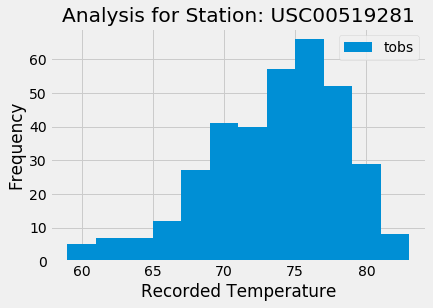

In [89]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == top_station).\
    filter(Measurement.date > query_date).\
    order_by(Measurement.date).all()

temperature_df=pd.DataFrame(temperature)
plt.hist(temperature_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Analysis for Station: " + top_station)
plt.legend(["tobs"], loc="best")

plt.savefig("temp.png")
plt.show()

In [90]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [92]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year = calc_temps('2011-02-28', '2011-03-05')
print(prev_year)

[(61.0, 69.75510204081633, 75.0)]


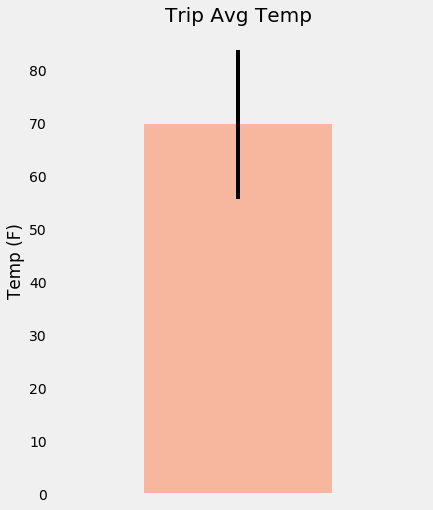

In [93]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

prev_year_df = pd.DataFrame(prev_year, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = prev_year_df['Avg Temp']
min_max_temp = prev_year_df.iloc[0]['Max Temp'] - prev_year_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()